In [11]:
# =====================================
# IMPORT LIBRARIES E IMPOSTAZIONI GENERALI
# =====================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Supervisionato
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Non Supervisionato
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

import joblib

# Stile grafici notebook
sns.set_style("whitegrid")
%matplotlib inline


In [12]:
# =====================================
# CARICAMENTO E PULIZIA DATASET
# =====================================
df = pd.read_csv("meteorite_clean.csv")

# Visualizza colonne originali
print("Colonne originali:", df.columns.tolist())

# Rimuovi spazi e minuscolizza
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Rinomina colonne per comodità
df.rename(columns={
    'mass_(g)': 'mass',
    'discovery_year': 'year'
}, inplace=True)

# Converti tipi numerici
numeric_cols = ['mass', 'reclat', 'reclong', 'year']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Rimuovi righe con valori mancanti critici
critical_cols = ['mass', 'reclat', 'reclong', 'year', 'fall']
df = df.dropna(subset=[col for col in critical_cols if col in df.columns])

# Filtra valori anomali
df = df[
    (df['mass'] > 0) & 
    (df['mass'] < 1e8) &
    (df['reclat'].between(-90, 90)) &
    (df['reclong'].between(-180, 180)) &
    (df['year'].between(1800, 2025))
].copy()

# Converti 'fall' in binario
df['fall_binary'] = (df['fall'] == 'Fell').astype(int)

print(f"Dati puliti: {df.shape[0]} righe rimanenti")
df['fall'].value_counts()


Colonne originali: ['name', 'id', 'nametype', 'recclass', 'mass (g)', 'fall', 'reclat', 'reclong', 'GeoLocation', 'discovery_year']
Dati puliti: 45696 righe rimanenti


fall
Found    44589
Fell      1107
Name: count, dtype: int64

In [13]:
# =====================================
# DATA CLEANING
# =====================================

# Rimuovi spazi dai nomi colonne
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Rinomina 'mass_(g)' in 'mass'
if 'mass_(g)' in df.columns:
    df.rename(columns={'mass_(g)': 'mass'}, inplace=True)

# Converti tipi numerici
numeric_cols = ['mass', 'reclat', 'reclong', 'year']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Rimuovi righe con valori mancanti critici
critical_cols = ['mass', 'reclat', 'reclong', 'year', 'fall']
df = df.dropna(subset=[col for col in critical_cols if col in df.columns])

# Filtra valori anomali
df = df[
    (df['mass'] > 0) & 
    (df['mass'] < 1e8) &
    (df['reclat'].between(-90, 90)) &
    (df['reclong'].between(-180, 180)) &
    (df['year'].between(1800, 2025))
].copy()

# Converti 'fall' in binario
df['fall_binary'] = (df['fall'] == 'Fell').astype(int)

print(f"Dati puliti: {df.shape[0]} righe rimanenti")
df['fall'].value_counts()


Dati puliti: 45696 righe rimanenti


fall
Found    44589
Fell      1107
Name: count, dtype: int64

In [14]:
# =====================================
# FEATURE ENGINEERING
# =====================================

# Temporali
df['year_normalized'] = (df['year'] - df['year'].min()) / (df['year'].max() - df['year'].min())
df['decade'] = (df['year'] // 10) * 10
df['age'] = 2025 - df['year']
df['is_modern'] = (df['year'] >= 1950).astype(int)
df['is_recent'] = (df['year'] >= 2000).astype(int)

# Geografiche
df['abs_lat'] = np.abs(df['reclat'])
df['abs_long'] = np.abs(df['reclong'])
df['hemisphere_north'] = (df['reclat'] >= 0).astype(int)
df['hemisphere_east'] = (df['reclong'] >= 0).astype(int)
df['dist_from_equator'] = df['abs_lat']
df['dist_from_prime_meridian'] = df['abs_long']
df['lat_rad'] = np.radians(df['reclat'])
df['long_rad'] = np.radians(df['reclong'])

# Quadranti
def assign_quadrant(lat, long):
    if lat >= 0 and long >= 0: return 'NE'
    elif lat >= 0 and long < 0: return 'NW'
    elif lat < 0 and long >= 0: return 'SE'
    else: return 'SW'
df['quadrant'] = df.apply(lambda x: assign_quadrant(x['reclat'], x['reclong']), axis=1)

# Massa
df['log_mass'] = np.log10(df['mass'] + 1)
df['mass_sqrt'] = np.sqrt(df['mass'])
df['mass_category'] = pd.cut(df['mass'], 
                              bins=[0, 100, 1000, 10000, 1e8],
                              labels=['very_small', 'small', 'medium', 'large'])
df['is_large'] = (df['mass'] > df['mass'].quantile(0.75)).astype(int)
df['is_tiny'] = (df['mass'] < df['mass'].quantile(0.25)).astype(int)

# Interazioni
df['mass_x_age'] = df['log_mass'] * df['age']
df['mass_x_lat'] = df['log_mass'] * df['abs_lat']
df['lat_x_long'] = df['reclat'] * df['reclong']
df['age_x_lat'] = df['age'] * df['abs_lat']

# Classe
if 'recclass' in df.columns:
    df['class_group'] = df['recclass'].str[0]
    le_class = LabelEncoder()
    df['recclass_encoded'] = le_class.fit_transform(df['recclass'].fillna('Unknown'))

# Densità per griglia 10x10
df['lat_grid'] = (df['reclat'] // 10) * 10
df['long_grid'] = (df['reclong'] // 10) * 10
grid_counts = df.groupby(['lat_grid', 'long_grid']).size()
df['grid_density'] = df.apply(lambda x: grid_counts.get((x['lat_grid'], x['long_grid']), 0), axis=1)

df.shape[1]


39

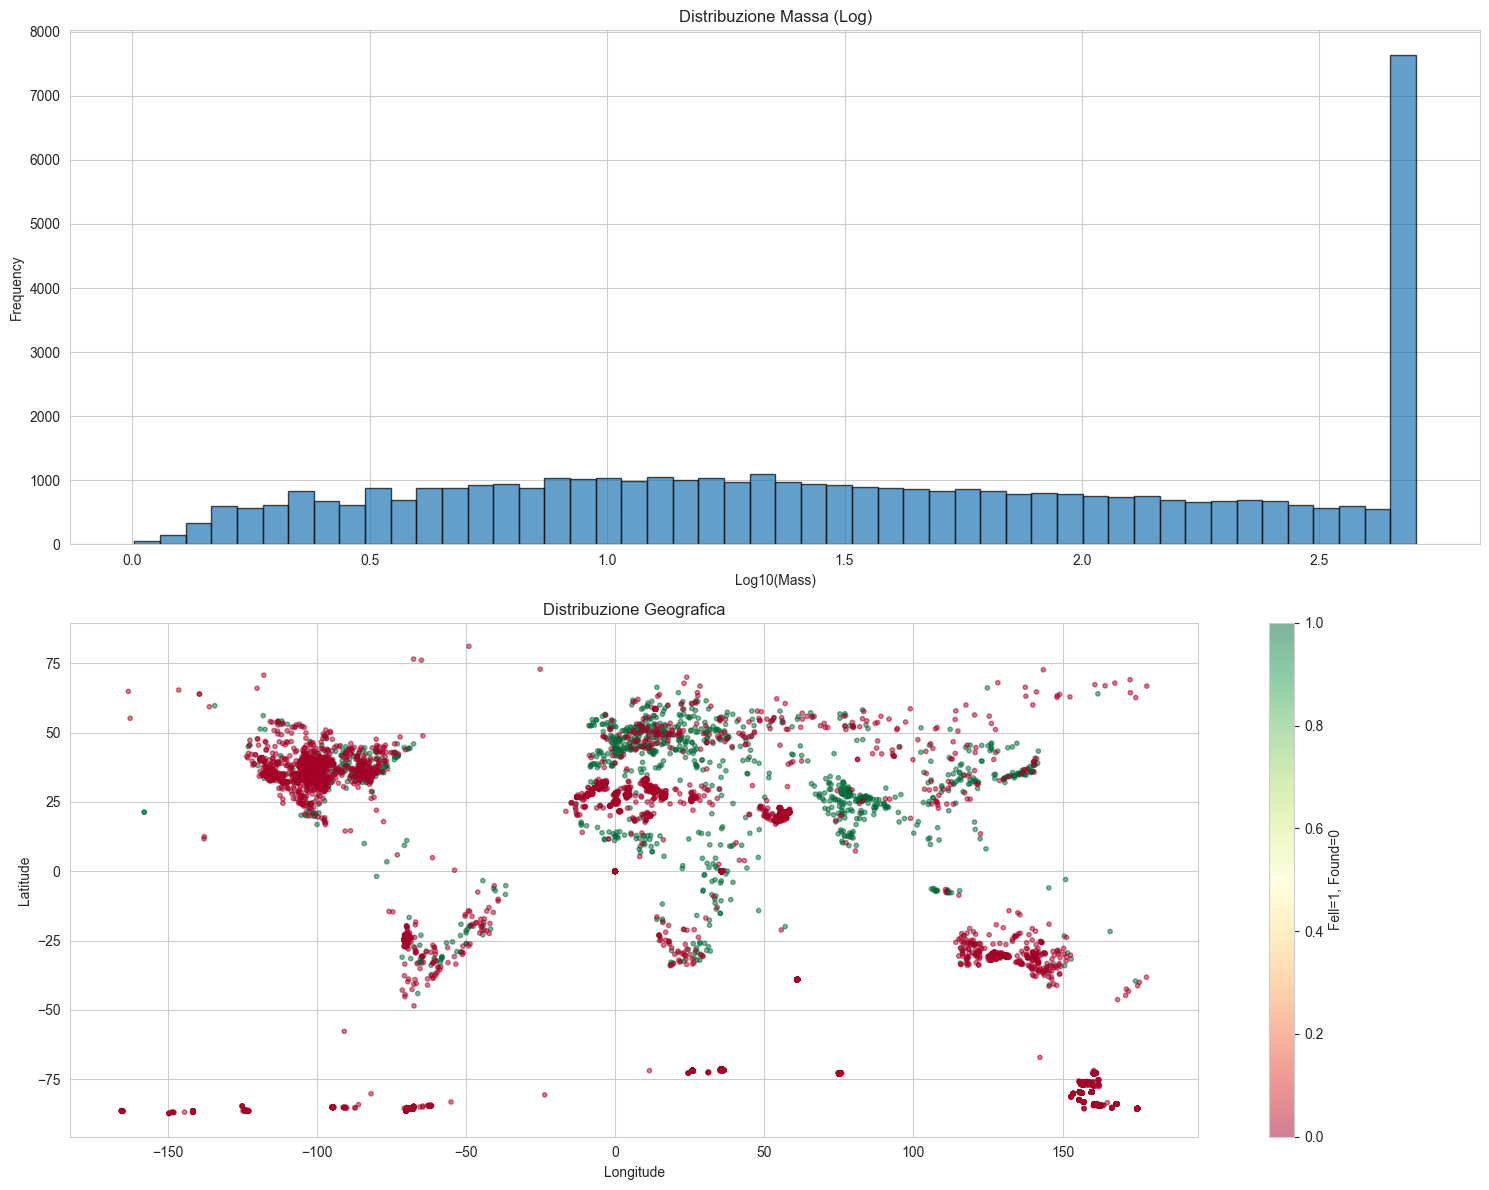

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(15,12))

# 1. Log-mass
axes[0].hist(df['log_mass'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribuzione Massa (Log)')
axes[0].set_xlabel('Log10(Mass)')
axes[0].set_ylabel('Frequency')

# 2. Distribuzione geografica
scatter = axes[1].scatter(df['reclong'], df['reclat'], c=df['fall_binary'], cmap='RdYlGn', alpha=0.5, s=10)
axes[1].set_title('Distribuzione Geografica')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
plt.colorbar(scatter, ax=axes[1], label='Fell=1, Found=0')

plt.tight_layout()
plt.show()


Test K values: 100%|██████████| 9/9 [04:13<00:00, 28.21s/it]


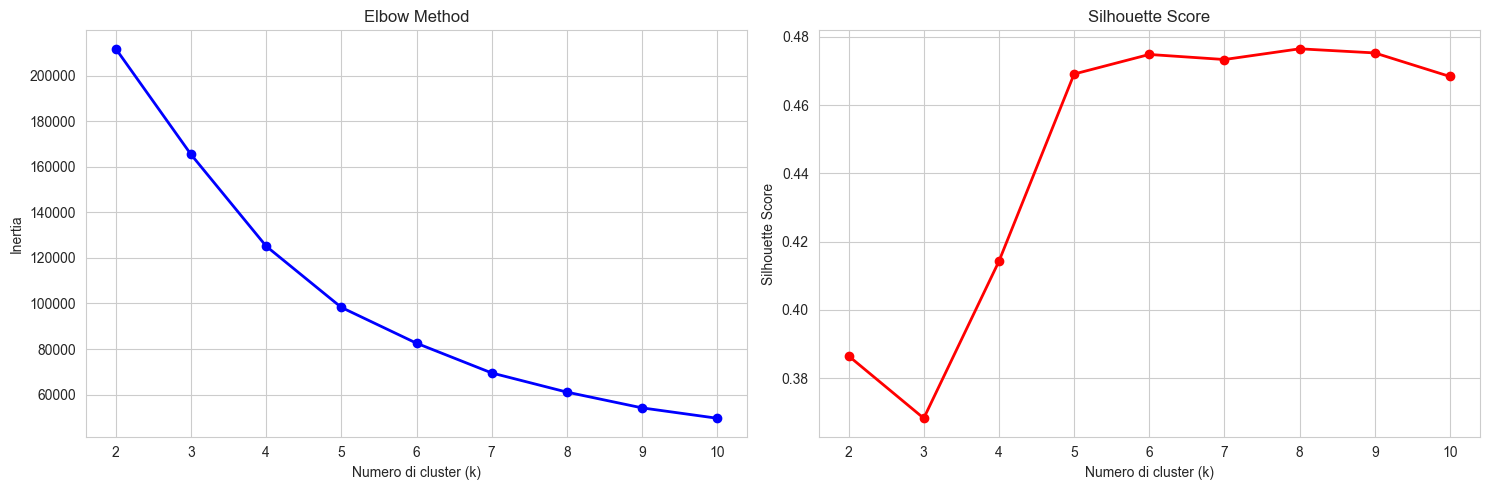

✅ Silhouette Score: 0.4143
✅ Davies-Bouldin Score: 1.0920


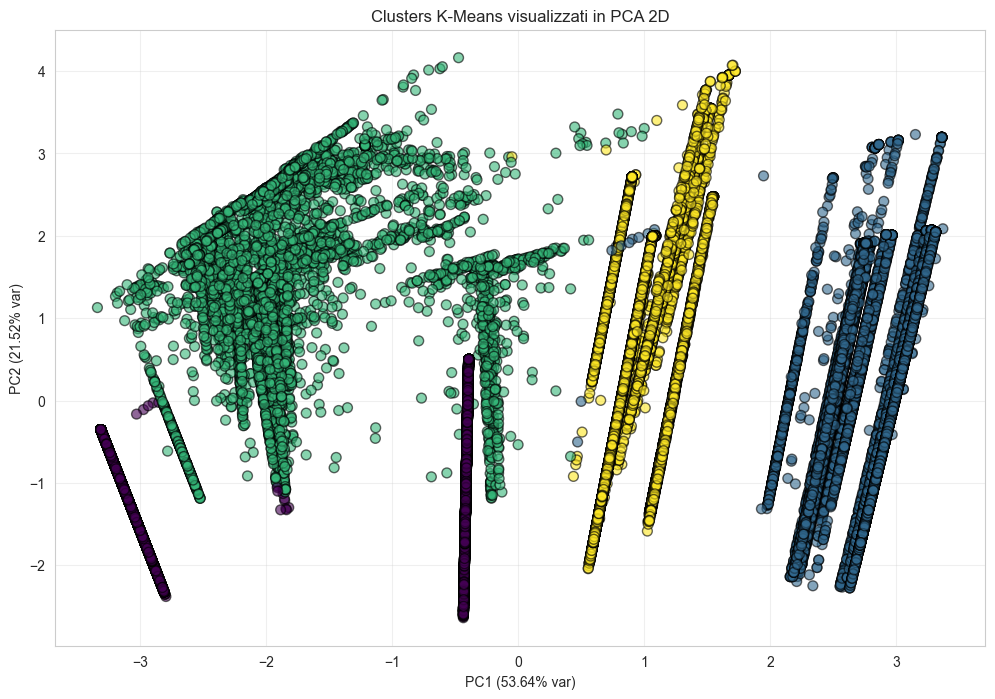

In [6]:
# =====================================
# K-MEANS CLUSTERING 
# =====================================

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# --- Selezione features per clustering ---
clustering_features = [
    'log_mass', 'reclat', 'reclong', 'year_normalized',
    'abs_lat', 'abs_long', 'age', 'dist_from_equator',
    'mass_x_lat', 'grid_density'
]

X_cluster = df[clustering_features].copy()

# --- Imputazione dei valori mancanti ---
imputer = SimpleImputer(strategy='median')
X_cluster_imputed = imputer.fit_transform(X_cluster)

# --- Standardizzazione ---
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster_imputed)

# --- Ottimizzazione del numero di cluster ---
K_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in tqdm(K_range, desc="Test K values"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, kmeans.labels_))

# --- Grafici Elbow e Silhouette ---
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=6)
axes[0].set_title('Elbow Method')
axes[0].set_xlabel('Numero di cluster (k)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=6)
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Numero di cluster (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# --- K-Means finale ---
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans_final.fit_predict(X_cluster_scaled)

# --- Metriche dei cluster ---
sil_score = silhouette_score(X_cluster_scaled, df['kmeans_cluster'])
db_score = davies_bouldin_score(X_cluster_scaled, df['kmeans_cluster'])
print(f"✅ Silhouette Score: {sil_score:.4f}")
print(f"✅ Davies-Bouldin Score: {db_score:.4f}")

# --- PCA per visualizzazione 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster_scaled)
df['pca1'], df['pca2'] = X_pca[:,0], X_pca[:,1]

plt.figure(figsize=(12,8))
plt.scatter(df['pca1'], df['pca2'], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6, s=50, edgecolors='black')
plt.title('Clusters K-Means visualizzati in PCA 2D')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} var)')
plt.grid(True, alpha=0.3)
plt.show()


In [7]:
# --- Selezione features ---
cols_to_exclude = [
    'fall','fall_binary','name','id','nametype','recclass','geolocation',
    'kmeans_cluster','dbscan_cluster','pca1','pca2',
    'mass_category','quadrant','class_group','lat_grid','long_grid'
]

feature_cols = [col for col in df.columns if col not in cols_to_exclude and df[col].dtype in ['int64','float64']]
X = df[feature_cols]
y = df['fall_binary']

# --- Imputazione valori mancanti ---
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# --- Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, stratify=y, random_state=42
)

# --- Standardizzazione ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# --- Modelli ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=35, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=35, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=35, learning_rate=0.1, max_depth=5, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=35, learning_rate=0.1, max_depth=5, random_state=42, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=35, learning_rate=0.1, num_leaves=31, random_state=42, verbose=-1)
}

# --- Training e valutazione ---
results, trained_models = [], {}
for name, model in tqdm(models.items(), desc="Training models"):
    model.fit(X_train_scaled, y_train)
    y_test_pred = model.predict(X_test_scaled)
    results.append({
        'Model': name,
        'Test_Accuracy': accuracy_score(y_test, y_test_pred)
    })
    trained_models[name] = model

results_df = pd.DataFrame(results).sort_values('Test_Accuracy', ascending=False)
results_df

Training models: 100%|██████████| 5/5 [00:18<00:00,  3.68s/it]


,Model,Test_Accuracy
1,Random Forest,0.989825
4,LightGBM,0.989497
2,Gradient Boosting,0.989497
3,XGBoost,0.988512
0,Logistic Regression,0.979978


Miglior modello: Random Forest
              precision    recall  f1-score   support

       Found       0.99      1.00      0.99      8919
        Fell       0.83      0.73      0.78       221

    accuracy                           0.99      9140
   macro avg       0.91      0.86      0.89      9140
weighted avg       0.99      0.99      0.99      9140



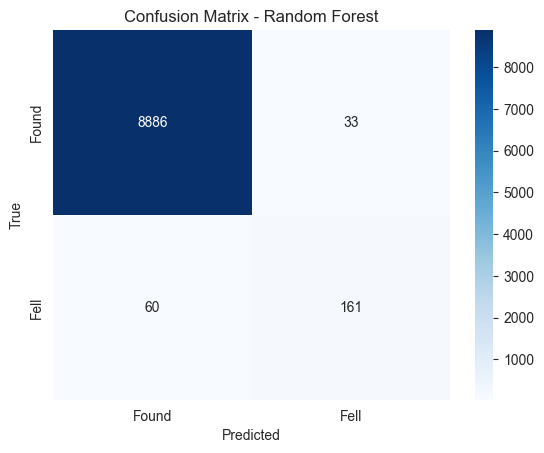

In [9]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)

print(f"Miglior modello: {best_model_name}")
print(classification_report(y_test, y_pred_best, target_names=['Found','Fell']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Found','Fell'], yticklabels=['Found','Fell'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


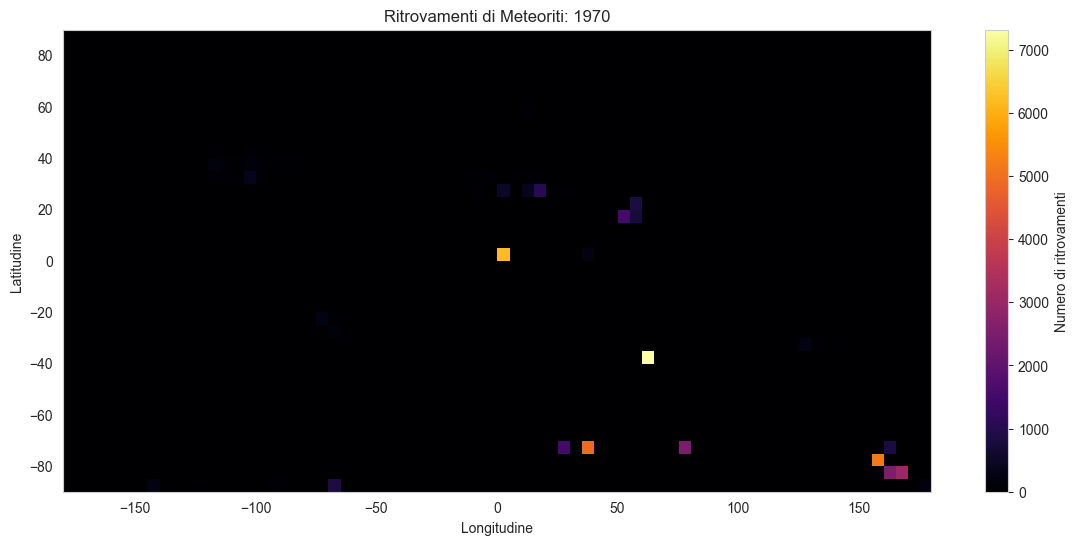

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time

# --- Preparazione dati ---
df['year_int'] = df['year'].astype(int)

lat_bin = 5
lon_bin = 5
df['lat_grid'] = (df['reclat'] // lat_bin) * lat_bin
df['lon_grid'] = (df['reclong'] // lon_bin) * lon_bin

# Aggrega per anno e griglia
heatmap_data = df.groupby(['year_int', 'lat_grid', 'lon_grid']).size().reset_index(name='Count')

# Lista anni ordinata
years = sorted(heatmap_data['year_int'].unique())

# Limiti mappa
lat_bins = np.arange(-90, 95, lat_bin)
lon_bins = np.arange(-180, 185, lon_bin)

# --- Animazione ---
for year in years:
    data_year = heatmap_data[heatmap_data['year_int']==year]
    
    # Matrice vuota
    heat_matrix = np.zeros((len(lat_bins)-1, len(lon_bins)-1))
    
    # Riempie la matrice
    for _, row in data_year.iterrows():
        lat_idx = np.digitize(row['lat_grid'], lat_bins) - 1
        lon_idx = np.digitize(row['lon_grid'], lon_bins) - 1
        heat_matrix[lat_idx, lon_idx] = row['Count']
    
    plt.figure(figsize=(14,6))
    plt.imshow(heat_matrix, origin='lower', cmap='inferno',
               extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
               aspect='auto')
    plt.colorbar(label='Numero di ritrovamenti')
    plt.title(f'Ritrovamenti di Meteoriti: {year}')
    plt.xlabel('Longitudine')
    plt.ylabel('Latitudine')
    plt.grid(False)
    plt.show()
    
    # Breve pausa tra i frame
    time.sleep(0.1)
    clear_output(wait=True)
